In [258]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.optimizers import Adam

2.3.1


In [259]:
from PIL import Image          
import numpy as np             
import os                      
from random import shuffle     
from tqdm import tqdm
import matplotlib.pyplot as plt

TRAIN_DIR = 'TRAIN'
TEST_DIR = 'TEST'

IMG_SIZE = 120
LR = 1e-3 #keep the deault = 0.001

In [260]:
def label_img(img):
    # Images are formatted as: ADIDAS_1, NIKE_3 ...
    
    word_label = img.split('_')[0]
    if word_label == 'NIKE': return [1,0]
    elif word_label == 'ADIDAS': return [0,1]
    # if data from .csv file
    #y = raw[:, 0] # true labels
    #out_y = keras.utils.to_categorical(y, 2) #two classes, where y has labels in decimal
def process_data(train=1):
    '''
    Creates a numpy array of images and (its labels (one hot encoding) if training data)
    Returns:
        Returns a 
        (a) numpy array of images that are matrices (IMG_SIZE x IMG_SIZE) and the labels that are vector (1x2) or
        (b) numpy array of images that are matrices (IMG_SIZE x IMG_SIZE) and a name of the file
    '''
    data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        img_num = img.split('_')[1] #images are formatted 'NIKE_2', 'ADIDAS_56'..
        
        path = os.path.join(TRAIN_DIR, img)        
        
        img = Image.open(path) 
        img = img.convert('L')
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
                
        #append label if training
        if train == 1:     
            data.append([np.array(img), np.array(label)])
            #np.save('train_data.npy', data) 
        else:
            data.append([np.array(img), img_num])
            #np.save('test_data.npy', data) 
            
    shuffle(data)
    return data

#test_data = process_test_data()
train_data = process_data(1)
test_data  = process_data(0)

100%|██████████| 100/100 [00:01<00:00, 69.52it/s]


[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([1, 0])]


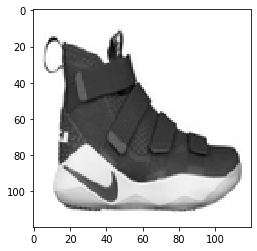

In [261]:
print(train_data[99])
plt.imshow(train_data[99][0], cmap = 'gist_gray')

In [262]:
print(test_data[99])

[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), '19.png']


# Convert back the train data to np.array

In [263]:
# https://www.kaggle.com/dansbecker/deep-learning-from-scratch
X = np.array([i[0]/255 for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)#train_data[-90:]
y = np.array([i[1] for i in train_data])
print(X.shape)
print(y.shape)

test_X = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # [:,-90]
test_y = np.array([i[1] for i in test_data])

print(test_X.shape)
print(test_y.shape)

(100, 120, 120, 1)
(100, 2)
(100, 120, 120, 1)
(100,)


(120, 120)


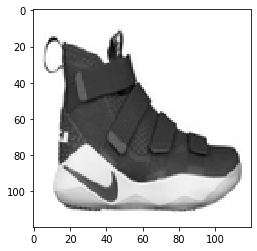

In [264]:
# silly checks 
print(X[99].reshape(IMG_SIZE, IMG_SIZE).shape)
plt.imshow(X[99].reshape(IMG_SIZE, IMG_SIZE), cmap = 'gist_gray')

## A general note on dimension reduction:

Ref: https://www.edureka.co/blog/interview-questions/data-science-interview-questions/#deep-learning


With 
- Input: W
- Filter: K
- Padding: P
- Stride: S

output  = (W – K + 1 + 2P) / S

`model.add(Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), input_shape=(8, 8, 1)))`

With W=8, K=3, P=0, S=1, the output is 6x6 with 3x3=9 weigths and 1 bias = 10 parameters

For `padding="same"` meaning no dim reduction, then P is chosen as P = (K-1)/2, therefore for

`model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same",
                     input_shape=(120, 120, 1)))`

With W=120, K=5, P=2, S=1, the output is 120x120, with 5x5x32=800 weight and 32 bias = 832 parameters 


For max pooling with `padding="valid"`, meaning no extra padding, therefore for input of 24x24

- `model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="valid"))`

    -  With pool_size=5x5, P=0 the dim reduction is 24/5 = 4x4 sized filters.
    

- `model.add(MaxPooling2D(pool_size=(7, 7), strides=None, padding="same"))`

    -  With pool_size=5x5, the dim reduction is (24+1)/5 = 5x5 sized filters. 
    
# Building the Model    

In [265]:
num_classes = 2
model = Sequential(name="shoe_cov2D_keras")

# first layer followed by max pooling layer
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same",
                     input_shape=(IMG_SIZE, IMG_SIZE, 1), name='Conv2D'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="same", name='MaxPool2D')) # dim_ordering="th" used in Keras

# second layer (hidden)
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same", name='Conv2D_1'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="same", name='MaxPool2D_1'))

# third layer (hidden)
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same", name='Conv2D_2'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="same", name='MaxPool2D_2'))

# fourth layer (hidden)
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same", name='Conv2D_3'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="same", name='MaxPool2D_3'))

# fifth layer (hidden)
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same", name='Conv2D_4'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="same", name='MaxPool2D_4'))

# sixth layer
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), activation='relu',  padding="same", name='Conv2D_5'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=None, padding="same", name='MaxPool2D_5'))


# fully connected layer
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))


#output layer
model.add(Dense(num_classes, activation='softmax'))

# compile
adam = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-8) #keep the deault = 0.001
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam, #'adam'
              metrics=['accuracy'])
# summary
print(model.summary())

# to further optimize the learning rates:
# https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

Model: "shoe_cov2D_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D (Conv2D)              (None, 120, 120, 32)      832       
_________________________________________________________________
MaxPool2D (MaxPooling2D)     (None, 24, 24, 32)        0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 5, 5, 64)          0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 5, 5, 32)          51232     
_________________________________________________________________
MaxPool2D_2 (MaxPooling2D)   (None, 1, 1, 32)          0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 1, 1, 64)     

# Run the Model

In [266]:
# checkpoint
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

#filepath="weights.best.hdf5"
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fit
history = model.fit(X, y,
          #batch_size=None, #None, 32
          epochs=100,
          #validation_data=(test_X, test_y), another way if training data is split at pre-processing       
          validation_split = 0.1,
          callbacks=callbacks_list,
          verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to weights-improvement-01-0.60.hdf5

Epoch 00002: val_accuracy did not improve from 0.60000

Epoch 00003: val_accuracy did not improve from 0.60000

Epoch 00004: val_accuracy did not improve from 0.60000

Epoch 00005: val_accuracy did not improve from 0.60000

Epoch 00006: val_accuracy did not improve from 0.60000

Epoch 00007: val_accuracy did not improve from 0.60000

Epoch 00008: val_accuracy did not improve from 0.60000

Epoch 00009: val_accuracy did not improve from 0.60000

Epoch 00010: val_accuracy did not improve from 0.60000

Epoch 00011: val_accuracy did not improve from 0.60000

Epoch 00012: val_accuracy did not improve from 0.60000

Epoch 00013: val_accuracy did not improve from 0.60000

Epoch 00014: val_accuracy did not improve from 0.60000

Epoch 00015: val_accuracy did not improve from 0.60000

Epoch 00016: val_accuracy did not improve from 0.60000

Epoch 00017: val_accuracy did not improve from 0.600

Text(0.5, 1.0, 'lrate=0.001')

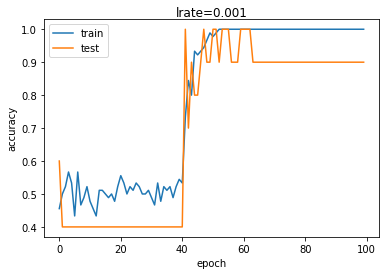

In [271]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('lrate='+str(LR), pad=-50)

# Results

Keras proved to be much efficient then TFLearn and much much fast. I used to spend 20 mins with TFLearn, and this is within a minute, with 100% accuracy.

class label: [1. 0.]
class label: [0. 1.]
class label: [1. 0.]
class label: [1. 0.]
class label: [0. 1.]
class label: [1. 0.]
class label: [0. 1.]
class label: [1. 0.]
class label: [0. 1.]
class label: [1. 0.]
class label: [0. 1.]
class label: [0. 1.]


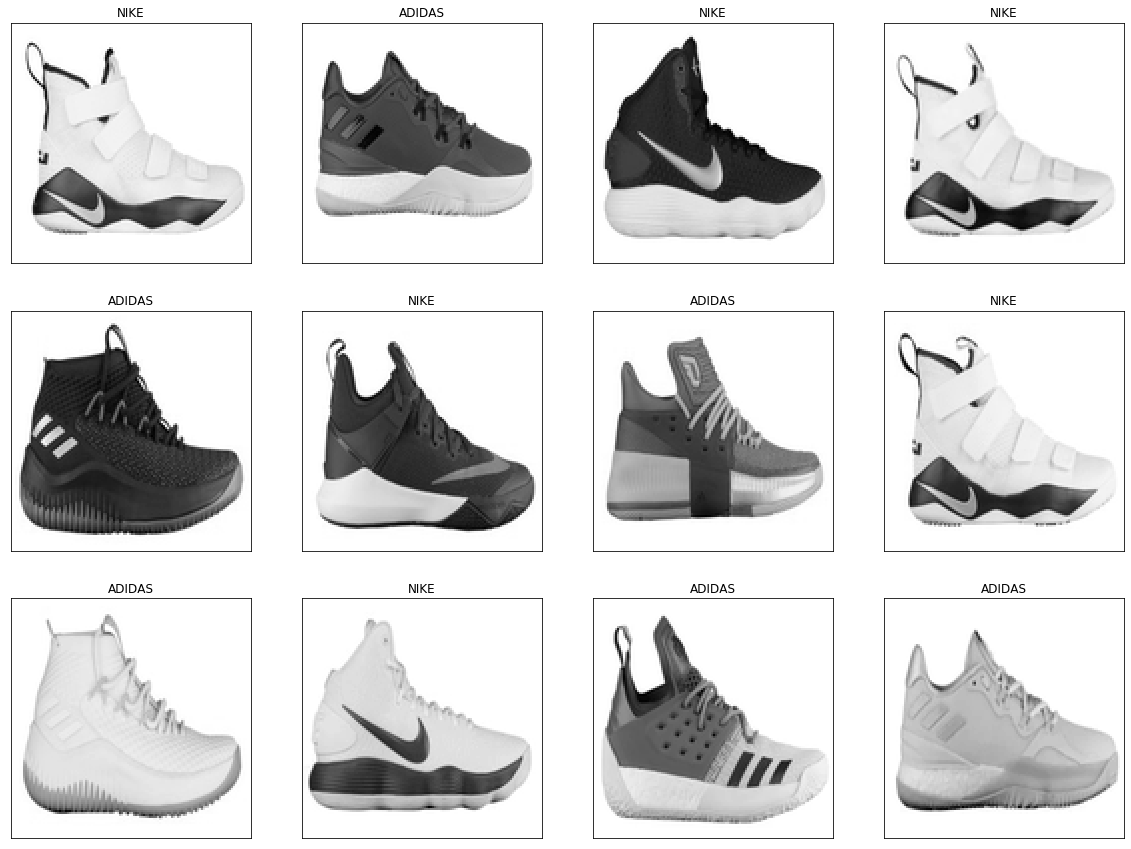

In [268]:
fig = plt.figure(figsize=(20,15))

for num, data in enumerate(test_data[-12:]):
    img_num = data[1]
    img_data = data[0]
    
    canvas = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1) #(120, 120, 1)
    
    model_out = model.predict([data])[0]
    print('class label:', model_out)
    #label_out = model.predict_label([data])[0]
    #print('prob:', model_out)
    
    if np.argmax(model_out) == 1:
        str_label = 'ADIDAS'
    else:
        str_label = 'NIKE'
    
    canvas.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    canvas.axes.get_xaxis().set_visible(False)
    canvas.axes.get_yaxis().set_visible(False)
    
plt.show()

In [270]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [194]:
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
print('Train: %.3f' % (train_acc))
#_, test_acc = model.evaluate(test_X, test_y, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000


In [ ]:
# to check the preformance w.r.t known architectures (TO DO)
'''
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
'''